# Алгоритмы анализа данных

### Урок 4. Алгоритм построения дерева решений

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).
2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.
3. [__опция__] Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

## <center> Практическое задание </center>

### Реализация из методички

In [1]:
import matplotlib.pyplot as plt
import random
import math

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2, 
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.75,
    random_state=5
)

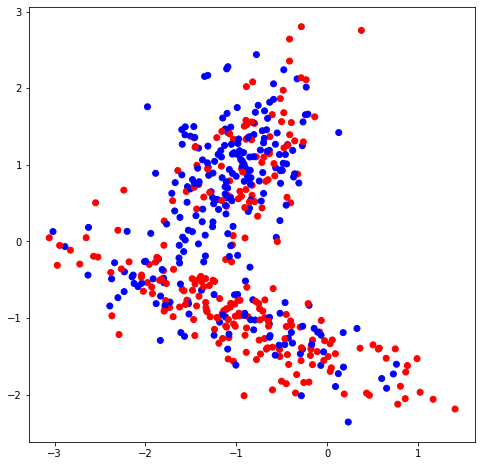

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

# 

За функционал качества при работе с деревом решений принимается функционал вида

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

где $X_{m}$ - множество объектов, попавших в вершину на данном шаге, $X_{l}$ и $X_{r}$ - множества, попадающие в левое и правое поддерево, соответственно, после разбиения. $H(X)$ - _критерий информативности_. $\frac{|X_{l}|}{|X_{m}|}\equiv p$ -  доля выбоки, ушедшая в левое поддерево:

$$Q(X_{m}, j, t) = H(X_{m}) - p\cdot H(X_{l}) - (1-p) \cdot H(X_{r}),$$


### Критерии информативности

__Критерий Джини__ или __индекс Джини__ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = \sum^{K}_{k=1}(p_{k}-p_{k}^2)=\sum^{K}_{k=1}p_k-\sum^{K}_{k=1}p_k^2=1-\sum^{K}_{k=1}p_k^2  ,$$

где $K$ - количество классов в наборе данных $X$.

In [6]:
# Расчет критерия Джини
# labels - Y_m
# data - X_m

def gini(labels):
    #  подсчет количества объектов разных поддеревьев
    classes = {}
    for label in labels:
        # значение отсутствует в classes, добавляем его
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    # labels = [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]
    # classes = {0: 7, 1: 5}
    # gini(labels) = 0.48611111111111094

    #  расчет критерия
    impurity = 1  # примесь
    for label in classes:
        p = classes[label] / len(labels)  # p=X_l/X_m
        impurity -= p ** 2
        
    return impurity

__Энтропийный критерий__ (__энтропиия Шеннона__)

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $0\cdot\text{log}_{2}0=0.$

In [7]:
# Cм. реализацию во 2-м задании

In [8]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # data - матрица признаков
        # labels это y - вектор значений (classification_labels)
        # index - номер признака
        # t - уникальные значения признака

        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# 

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    # data - матрица признаков
    # labels это y - вектор значений
    # index - номер признака
    # t - уникальные значения признака   
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    # Получаем ответы
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size = 0.3, random_state = 1
)

In [14]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

## <center> Практическое задание </center>

### 1. Задача:
В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [15]:
# Построение дерева с помощью рекурсивной функции

# Реализуем критериев останова - max глубина дерева
def build_tree(data, labels, depth=0):

    # data - матрица признаков
    # labels это y - вектор значений (classification_labels)
    # index - номер признака
    # t - уникальные значения признака

    global max_depth

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    #  1 случай - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if depth < max_depth:

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, depth + 1)
        false_branch = build_tree(false_data, false_labels, depth + 1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    return Leaf(data, labels)

In [16]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [17]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def plot_tree(my_tree, train_data, train_labels):
    
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')    

In [18]:
# Задаём максимальную глубину дерева
max_depth = 3

# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [19]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [20]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [21]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

68.28571428571428

In [22]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

60.66666666666667

<ipython-input-17-21e2eca715e1>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-17-21e2eca715e1>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


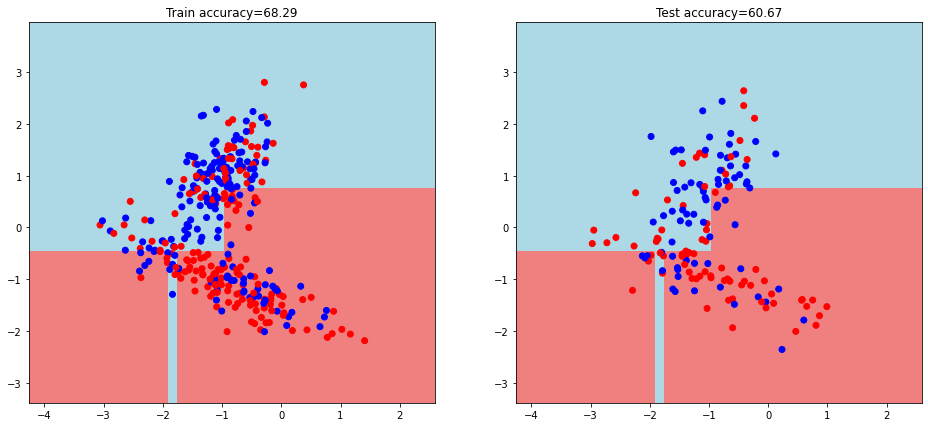

In [23]:
# Визуализируем дерево на графике
plot_tree(my_tree, train_data, train_labels)

In [24]:
print(f'Максимальную глубину дерева max_depth={max_depth}')

# Напечатаем ход нашего дерева
print_tree(my_tree)

Максимальную глубину дерева max_depth=3
Индекс 1
Порог -0.46624201061399206
--> True:
  Индекс 0
  Порог -1.79696585158631
  --> True:
    Индекс 0
    Порог -1.9226384124885603
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0
    Порог -1.1834902220493384
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
--> False:
  Индекс 0
  Порог -0.9820958539320116
  --> True:
    Индекс 0
    Порог -1.6445609784573159
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Индекс 1
    Порог 0.7329350213251566
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1


# 

In [25]:
# Задаём максимальную глубину дерева
max_depth = 10

# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [26]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [27]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [28]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

79.42857142857143

In [29]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

57.333333333333336

Максимальную глубину дерева max_depth=10


<ipython-input-17-21e2eca715e1>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-17-21e2eca715e1>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


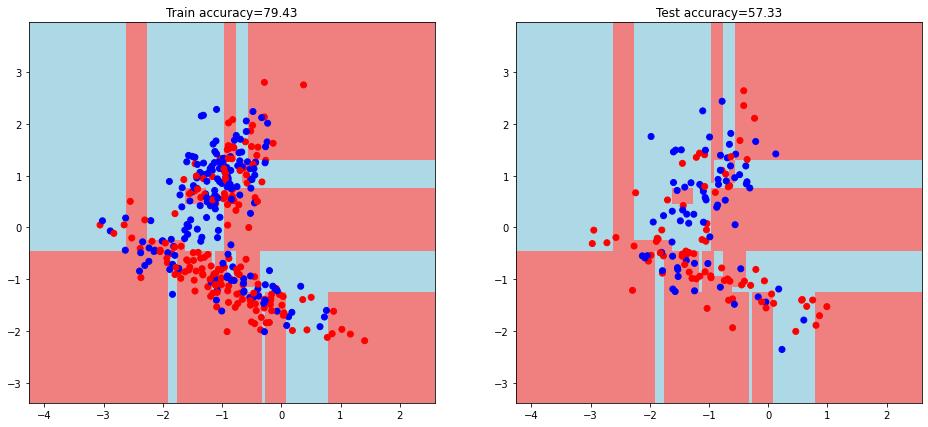

In [30]:
print(f'Максимальную глубину дерева max_depth={max_depth}')

plot_tree(my_tree, train_data, train_labels)

In [31]:
print(f'Максимальную глубину дерева max_depth={max_depth}')

# Напечатаем ход нашего дерева
print_tree(my_tree)

Максимальную глубину дерева max_depth=10
Индекс 1
Порог -0.46624201061399206
--> True:
  Индекс 0
  Порог -1.79696585158631
  --> True:
    Индекс 0
    Порог -1.9226384124885603
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0
    Порог -1.1834902220493384
    --> True:
      Индекс 0
      Порог -1.6959366052924192
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 1
      Порог -1.2659561512192585
      --> True:
        Индекс 0
        Порог 0.7624451741809175
        --> True:
          Индекс 0
          Порог 0.04595444880264021
          --> True:
            Индекс 0
            Порог -0.2708916550945537
            --> True:
              Индекс 0
              Порог -0.3360165595341751
              --> True:
                Индекс 1
                Порог -1.4091570001288853
                --> True:
                  Индекс 0
                  Порог -0.7776944655001441
                 

### 2. Задача:
Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

### Критерии информативности

__Энтропийный критерий__ (__энтропиия Шеннона__)

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $$0\cdot\text{log}_{2}0=0$$

In [32]:
# Расчёт энтропии Шеннона - 2-е практическое задпние 

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p==0:
            impurity -= 0  # полагается, что 0⋅log 0 = 0
        else:
            # impurity -= p*math.log2(p)
            impurity -= p*(np.log(p)/np.log(2))  # используем правило изменения базы логарифмов
        
    return impurity

In [33]:
# Расчет качества

def quality_entropy(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [34]:
# Нахождение наилучшего разбиения используя энтропийный критерий Шеннона

def find_best_split_entropy(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_entropy(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [35]:
# Реализуем критериев останова - max глубина дерева

def build_tree_entropy(data, labels, depth=0):

    # data - матрица признаков
    # labels это y - вектор значений (classification_labels)
    # index - номер признака
    # t - уникальные значения признака

    global max_depth

    quality, t, index = find_best_split_entropy(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    #  1 случай - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if depth < max_depth:

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree_entropy(true_data, true_labels, depth + 1)
        false_branch = build_tree_entropy(false_data, false_labels, depth + 1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    return Leaf(data, labels)

In [36]:
# Задаём максимальную глубину дерева
max_depth = 10

# Построим дерево по обучающей выборке
my_tree = build_tree_entropy(train_data, train_labels)

In [37]:
# Напечатаем ход нашего дерева
# Максимальная глубина дерева max_depth = 3
# print_tree(my_tree)

In [38]:
print(f'Максимальную глубину дерева max_depth={max_depth}')

Максимальную глубину дерева max_depth=10


In [39]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [40]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [41]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

80.57142857142857

In [42]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

54.0

Максимальную глубину дерева max_depth=10


<ipython-input-17-21e2eca715e1>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-17-21e2eca715e1>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


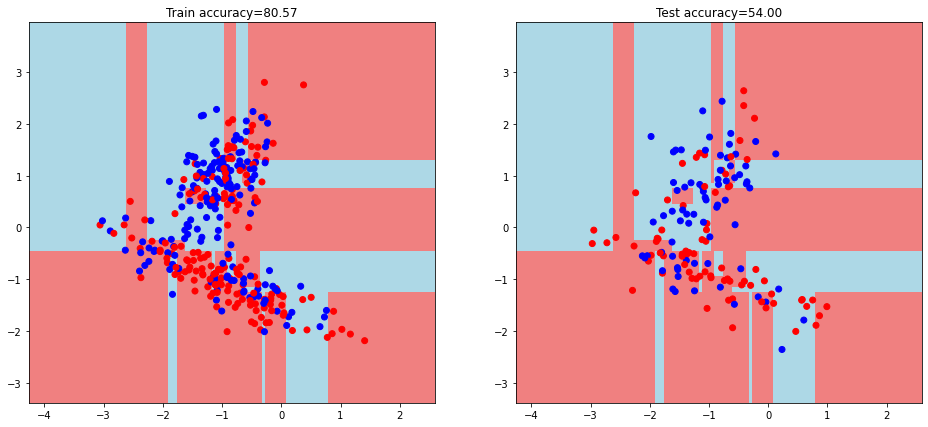

In [43]:
print(f'Максимальную глубину дерева max_depth={max_depth}')

# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

plot_tree(my_tree, train_data, train_labels)

Дерево строит кусочно-постоянную разделяющую гиперплоскость, то есть состоящую из прямых, параллельных осям. Чем глубже дерево, тем сложнее гиперплоскость. Также происходит и в случае регрессии - график зависимости целевого значения восстанавливается кусочно-постоянной функцией.

In [44]:
print(f'Максимальную глубину дерева max_depth={max_depth}')
# Напечатаем ход нашего дерева
# print_tree(my_tree)

Максимальную глубину дерева max_depth=10


# 

Максимальную глубину дерева max_depth=10<br />

__Критерий Джини (индекс Джини)__<br />
Точность на обучающей выборке train_accuracy=79.42857142857143<br />
Точность на тестовой выборке test_accuracy=57.333333333333336<br /><br />

__Энтропийный критерий (энтропия Шеннона)__<br />
Точность на обучающей выборке train_accuracy=80.57142857142857<br />
Точность на тестовой выборке test_accuracy=54.0<br />

__Вывод:__

При одинаковых параметрах задачи использование ___энтропийного критерия___, повысило точность на обучающей выборке, но понизило точность на тестовой выборке.

### 3 [опция]:
Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.